In [ ]:
### ATTENTION SUMMONER, KANOUME SCALE KAI TA OUTER_TRAINING_DATA H OXI GAMW TO KERATO MOU TO TRAGIO? KI AN NAI,
### TO LOGIKO FAINETAI NA EINAI NA TO KANOUME ME DIKO TOUS SCALER KI OXI ME TO INNER. EINAI OMWS LOGIKO???????

In [1]:
import numpy as np
import os
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, f_classif, mutual_info_classif
import time
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RandomizedLasso
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold #, GridSearchCV, cross_val_score

%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib
from mpl_toolkits.mplot3d import Axes3D #, axes3d
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
import itertools


import operator
import winsound



In [2]:
datapath = 'data/'
XYfile = datapath + 'newfeatures_1024_1_10_10000_XY.npz'
Xpcafile = datapath + 'newfeatures_1024_1_10_10000_dimred.npz'
Xtestsds = datapath + 'newfeatures_1024_1_10_10000_testds.npz'
############# GATHERING into one complete array
#X = np.load(XYfile)['X']
with np.load(XYfile, encoding = 'latin1') as inpf:
    X = inpf['X']
    Y = inpf['Y']
# with np.load(Xpcafile, encoding = 'latin1') as inpf:
#     X = inpf['Xpca']
#     Y = inpf['Y']
#Y = np.load(XYfile)['Y']
# with np.load(Xtestsds, encoding = 'latin1') as inpf:
#     X = inpf['ds']


print ('gathered features: ', X[0].shape, Y[0].shape, X[1].shape, Y[1].shape, X[2].shape, Y[2].shape, np.sum(Y[2]))

gathered features:  (10063, 6216) (10063,) (10086, 6216) (10086,) (20149, 6216) (20149,) 9493.0


In [3]:
def make_pipe(clf,sca,order):
# order = 1 : first perform feature selection and then apply PCA
# order = 0 : first apply PCA and then reduce the transformed features
    if order:
        pipeline = Pipeline([('scaler', sca),
                    ('feature_selection', SelectKBest(mutual_info_classif)),
                    ('decomp', PCA()),        
                    ('classifier', clf) ])
    else:
        pipeline = Pipeline([('scaler', sca),
                    ('decomp', PCA()),                 
                    ('feature_selection', SelectKBest(mutual_info_classif)),        
                    ('classifier', clf) ])
    return pipeline

In [21]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

   
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
   
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# cnf_matrix = confusion_matrix(y_test, y_pred)
# np.set_printoptions(precision=2)

In [4]:
import pandas as pd 
from sklearn.preprocessing import LabelEncoder


df = pd.read_csv("sonar.csv",header = None)
dataset = df.values
Xsonar = dataset[:, 0:60].astype(float)
Ysonar = dataset[:,60]
#change the string output to int 
encoder = LabelEncoder()
encoder.fit(Ysonar)
ysonar = encoder.transform(Ysonar)

In [7]:
# copied 
window = 1024

## Time Domain Phinyomark feats
featnames = ['intsgnl', 'meanabs', 'meanabsslp', 'ssi', 'var', 'rms', 'rng', 'wavl', 'zerox', 'ssc', 'wamp', 
             'shist1', 'shist2', 'shist3']                                                   # 11+3{shist}
## Frequency Domain Phinyomark feats
featnames += ['arco1', 'arco2', 'arco3', 'mnf', 'mdf', 'mmnf', 'mmdf']                       # 3{arco}+4{mf}
featnames += ['reFFT{:03d}'.format(i) for i in range(window//2+1)]                            # samples/2+1{RF}
featnames += ['imFFT{:03d}'.format(i) for i in range(window//2+1)]                            # samples/2+1{IF}
## Time Domain Golz feats
featnames += ['meanv', 'stdr', 'mx', 'rngx', 'rngy', 'med', 'hjorth', 'sentr', 'se', 'ssk']  # 10
featnames += ['acrol{:04d}'.format(i) for i in range(window)]                                # samples{acrol}
## Frequency Domain Golz feats
featnames += ['amFFT{:03d}'.format(i) for i in range(window//2+1)]                            # samples/2+1{AF}
featnames += ['phFFT{:03d}'.format(i) for i in range(window//2+1)]                            # samples/2+1{PF}
featnames += ['ffaf']                                                                        # 1{ffaf}

In [ ]:
######################################## FEATURE SELECTION #########################################################
# feature names

shift =1 ; keepfromshift = 10; samplesperdataset = 10000

tmpind = {}
tmpind[2] = range(X[0].shape[1])
tmpind[0] = range(X[0].shape[1]//2)
tmpind[1] = range(X[0].shape[1]//2,X[0].shape[1])
tmpind = np.array([i for _,i in tmpind.items()])

featpath = datapath+'features/'+str(window)+'_'+str(shift)+'/'
featname = 'newfeatures'+'_'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)



numfeat = 10 # number of features to show
nfeat = 1000 # number of features to keep
#namesid = ['sf{:04d}'.format(i) if i<X[0].shape[1]/2 else 'ftn{:04d}'.format(i) for i in range(X[0].shape[1])]
namesid = [['sf{:04d}'.format(i) for i in range(X[0].shape[1]//2)],
           ['ftn{:04d}'.format(i) for i in range(X[0].shape[1]//2)],
           ['sf{:04d}'.format(i) if i<X[0].shape[1]//2 else 'ftn{:04d}'.format(i%X[0].shape[1]//2) for i in range(X[0].shape[1])]]
namesf = [['sf_{}'.format(featnames[i]) for i in range(X[0].shape[1]//2)],
         ['ftn_{}'.format(featnames[i]) for i in range(X[0].shape[1]//2)],
         ['sf_{}'.format(featnames[i]) if i<X[0].shape[1]//2 else 'ftn_{}'.format(featnames[i%X[0].shape[1]//2]) for i in range(X[0].shape[1])]]
########## use RandomizedLasso of MutualInfo as the model to select features and find their importances ############
featselfile = featpath+featname+'_featselall'+'.npz'
tmpskip = [int(len(tmpind[i])/3000) for i in range(len(tmpind))]
#tmpskip = [1 for i in range(3)]
start_time = time.time()
if os.path.isfile(featselfile):
    print("hey yooooo")
    #rlasso = np.load(featselfile)['rlasso'].tolist()
    featsel = np.load(featselfile)['featsel'].tolist()
    print("Selected Features FOUND PRECOMPUTED! Loading DONE in: %s seconds " % (time.time() - start_time))
else:                                                                                                    
    with warnings.catch_warnings():
        print("You're in for a long ride")
        warnings.simplefilter('ignore', UserWarning)
        warnings.simplefilter('ignore', ConvergenceWarning)
        featsel = [[SelectKBest(mutual_info_classif,'all').fit(X[i][:-1:tmpskip[i],tmpind[j]],Y[i][:-1:tmpskip[i]]) 
                    for j in range(3)] for i in range(3)]
        print("Selected Features NOT FOUND PRECOMPUTED! Selection DONE in: %s seconds " % (time.time() - start_time))
        # loop for all datasets (12,3,all) and all features (sf,ftn,all)
        #featsel = [[RandomizedLasso(fit_intercept=False,normalize=False).fit(X[i][:-1:tmpskip[i],tmpind[j]],Y[i][:-1:tmpskip[i]]) 
        #Parallel(n_jobs=-1)([delayed(feat) (p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)])
#         featsel = [Parallel(n_jobs=-1)([delayed(SelectKBest(mutual_info_classif,'all').fit) 
#                     (X[i][:-1:tmpskip[i],tmpind[j]],Y[i][:-1:tmpskip[i]])
#                     for i,j in itertools.product(range(len(X)),range(3))])]
#         featsel = np.array([[featsel[0][i*len(range(3))+j] for j in range(3)] for i in range(len(X))])
#                    for j in range(3) for i in range(len(X))]
        
        #np.savez(featselfile,rlasso=np.array(rlasso))
        np.savez(featselfile,featsel=featsel)
# rank features
# print "----> Features sorted by their rank (std norm):"
bestix = {}
wrstix = {}
# for i in range(len(X)): # for all diff data sets
# Im only using the first one so the for above doesnt apply
for i in range (3):
    bestix[i] = {}
    wrstix[i] = {}
    for j in range(3): # for all diff feature sets
#         tmp = sorted(zip(map(lambda x: round(x,4), featsel[i][j].scores_),namesf[j]),reverse=True)
        print(j)
        bestix[i][j] = np.array(featsel[i][j].scores_).argsort()[:][::-1]
        #wrstix[i][j] = np.array(featsel[i][j].scores_).argsort()[:nfeat][::1]
        wrstix[i][j] = np.array(featsel[i][j].scores_).argsort()[:][::1]
#         print 'Best '+str(numfeat)+': ',tmp[:numfeat], bestix[i][j].shape, bestix[i][j][:numfeat]
#         print 'Worst '+str(numfeat)+': ',tmp[-numfeat:], wrstix[i][j].shape, wrstix[i][j][:numfeat]
bestix = np.array([[ij for _,ij in i.items()] for _,i in bestix.items()])
wrstix = np.array([[ij for _,ij in i.items()] for _,i in wrstix.items()])

In [128]:
# Nested CV in order to evaluate the models' expected performance
# Since feature selection and normalization are a part of the model's
# construction, they should be performed inside the CV to avoid over-optimistic
# errors. Normalizing the whole dataset leaks future information to the estimators
# thus, you should only normalize the train set and then use mean and std to normalize
# test/val set. In that regard, the inner training set is normalized, its params are used
# on the inner test set and then the outer training set is normalized accordingly

struct = [
      [ {'gamma': np.arange(0.02,5,0.5), 'C':[0.1, 1, 10]},
       {'n_neighbors' : [2, 5, 10, 15]},
       {'alpha': [0.0001, 0.01, 0.1, 1], 'hidden_layer_sizes': [(100,100), (50,)]}
      ],
      [SVC(C=10), 
       KNeighborsClassifier(),
       MLPClassifier()]]
# struct = [
#     [], [KNeighborsClassifier()]
# ]
classifiers = struct[1]

# X,y = X[2,0], Y[2]
x_tot = np.copy(X[2]) ; y_tot = np.copy(Y[2])
x_tot = x_tot[0: :50] ; y_tot = y_tot[0: :50]

# x_tot = np.copy(X[1,1,2])
# y_tot = np.copy (Y[1])  
# x_tot = np.copy(Xsonar)
# y_tot = np.copy(ysonar)

n_outer_folds = 5
n_inner_folds = 5
state = 42 
nfeat = 10 # number of features to keep
ncomp = 5 # number of components to keep 
n_top_models = 2 # define the number of bests ranking classifiers

best_feat_ind = np.zeros((n_top_models,nfeat))

outer_scores = np.zeros((n_top_models, n_outer_folds)) 

#list containing all the clf and their respective pipelines
pipeline = [make_pipe(clf, sca = StandardScaler(), order = 1) for clf in classifiers]

#outer loop i.e. the one that evaluates the inner "best" model
outer_kfold = StratifiedKFold(n_splits = n_outer_folds, shuffle = True, random_state = state)
outer = outer_kfold.split(x_tot,y_tot)
# list containing the best 'n_top_models' for each fold 
best_pipes = [[],[]]

for fold_out, (train_ind_out, test_ind_out) in enumerate(outer):
    top_classifiers = []
    print("Outer loop %d/%d" %((fold_out + 1), n_outer_folds))
    
    # split the dataset 
    x_trn_out, x_tst_out = x_tot[train_ind_out], x_tot[test_ind_out]
    y_trn_out, y_tst_out = y_tot[train_ind_out], y_tot[test_ind_out]  

    inner_scores = np.zeros((len(classifiers),n_inner_folds))
    inner_mean_scores = np.zeros(len(classifiers))
    inner_scores2 = np.zeros((len(classifiers),n_inner_folds))
    inner_mean_scores2 = np.zeros(len(classifiers))

    for cl_ind,clf in enumerate(classifiers):
        
        inner_kfold = StratifiedKFold( n_splits = n_inner_folds, shuffle = True, random_state = state)
        inner = inner_kfold.split(x_trn_out, y_trn_out)

        for fold_in, (train_ind_in, test_ind_in) in enumerate(inner): 
            print("Inner fold %d/%d" % ((fold_in + 1), n_inner_folds ))
            # split the datasets for the inner cv 
            x_trn_in, x_tst_in = x_trn_out[train_ind_in], x_trn_out[test_ind_in]
            y_trn_in, y_tst_in = y_trn_out[train_ind_in], y_trn_out[test_ind_in]
            
            pip = pipeline[cl_ind].fit(x_trn_in,y_trn_in)
            inner_scores[cl_ind][fold_in] = pip.score(x_tst_in, y_tst_in)
                 
    # get the mean performance for every classifier
    inner_mean_scores = np.mean(inner_scores, axis = 1)
    print('\n',inner_mean_scores)
    
    # sort the scores, low -> high 
    sorted_inds = inner_mean_scores.argsort()
    sorted_scores = inner_mean_scores[sorted_inds]
    
    print ("Best %d models for outer fold %d are: \n " %(n_top_models, (fold_out+1)))
    
    #get the inds of best performing models
    temp2 = 0
    for temp_ind in range(-1, -(n_top_models +1), -1):
        actual_ind = sorted_inds[temp_ind]
        best_pipes[1].append(pipeline[actual_ind]) 
        best_pipes[0].append(fold_out)
        print("model no.%d "%actual_ind)
        print(pipeline[actual_ind].named_steps['clf'])
        #print the top features selected
        best_fs = pipeline[actual_ind].named_steps['feature_selection']
        pipe_fs_unsorted = best_fs.scores_
        fs_inds = pipe_fs_unsorted.argsort()
        pipe_fs = pipe_fs_unsorted[fs_inds]
        temp3 = 0 # temp3 = 0:number of features
        
        for temp_ind2 in range(-1, -(nfeat +1), -1):         
            best_feat_ind[temp2][temp3] = fs_inds[temp_ind2]
            temp3+=1
            
        #fit the best classifier on the outer test data
        pipeline[actual_ind].fit(x_trn_out, y_trn_out)
        #get the outer score 
        outer_scores[temp2, fold_out] = pipeline[actual_ind].score(x_tst_out, y_tst_out)
        print("Inner score: %f VS Outer score: %f \n" %(inner_mean_scores[actual_ind], outer_scores[temp2, fold_out]))
        print ("----------------------------------------------------------")
        temp2+=1

        
    print("Features selected: \n")
#     print(best_feat_ind.sort())     
    print(best_feat_ind)
# print(outer_scores)  
# print(best_pipes)
winsound.Beep(400,900)

Outer loop 1/5
Inner fold 1/5
Inner fold 2/5
Inner fold 3/5
Inner fold 4/5
Inner fold 5/5
Inner fold 1/5
Inner fold 2/5
Inner fold 3/5
Inner fold 4/5
Inner fold 5/5
Inner fold 1/5


C:\Users\Ifoundacarrot\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Inner fold 2/5
Inner fold 3/5


C:\Users\Ifoundacarrot\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Inner fold 4/5
Inner fold 5/5


C:\Users\Ifoundacarrot\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)



 [ 0.73257576  0.74166667  0.71685606]
Best 2 models for outer fold 0 are: 
 
model no.1 
Inner score: 0.741667 VS Outer score: 0.814815 

----------------------------------------------------------
model no.0 
Inner score: 0.732576 VS Outer score: 0.777778 

----------------------------------------------------------
Features selected: 

None
[[    7.  1324.  1325.  1326.  1460.  1461.  1462.  1463.  1464.  1465.]
 [    7.  1324.  1325.  1326.  1460.  1461.  1462.  1463.  1464.  1465.]]
Outer loop 2/5
Inner fold 1/5
Inner fold 2/5
Inner fold 3/5
Inner fold 4/5
Inner fold 5/5
Inner fold 1/5
Inner fold 2/5
Inner fold 3/5
Inner fold 4/5
Inner fold 5/5
Inner fold 1/5
Inner fold 2/5


C:\Users\Ifoundacarrot\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Inner fold 3/5
Inner fold 4/5
Inner fold 5/5


C:\Users\Ifoundacarrot\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)



 [ 0.69895833  0.76751894  0.70198864]
Best 2 models for outer fold 1 are: 
 
model no.1 
Inner score: 0.767519 VS Outer score: 0.851852 

----------------------------------------------------------
model no.2 


C:\Users\Ifoundacarrot\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Inner score: 0.701989 VS Outer score: 0.666667 

----------------------------------------------------------
Features selected: 

None
[[    7.   535.   556.   573.   576.   590.   597.  3115.  3118.  4157.]
 [    7.   535.   556.   567.   573.   576.   590.   597.  3115.  4157.]]
Outer loop 3/5
Inner fold 1/5
Inner fold 2/5
Inner fold 3/5
Inner fold 4/5
Inner fold 5/5
Inner fold 1/5
Inner fold 2/5
Inner fold 3/5
Inner fold 4/5
Inner fold 5/5
Inner fold 1/5


C:\Users\Ifoundacarrot\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Inner fold 2/5


C:\Users\Ifoundacarrot\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Inner fold 3/5
Inner fold 4/5
Inner fold 5/5


C:\Users\Ifoundacarrot\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)



 [ 0.70189394  0.77007576  0.67689394]
Best 2 models for outer fold 2 are: 
 
model no.1 
Inner score: 0.770076 VS Outer score: 0.802469 

----------------------------------------------------------
model no.0 
Inner score: 0.701894 VS Outer score: 0.666667 

----------------------------------------------------------
Features selected: 

None
[[ 2009.  3115.  4157.  4255.  4257.  4258.  4278.  4279.  4280.  4281.]
 [ 2009.  3115.  4157.  4255.  4257.  4258.  4278.  4279.  4280.  4281.]]
Outer loop 4/5
Inner fold 1/5
Inner fold 2/5
Inner fold 3/5
Inner fold 4/5
Inner fold 5/5
Inner fold 1/5
Inner fold 2/5
Inner fold 3/5
Inner fold 4/5
Inner fold 5/5
Inner fold 1/5


C:\Users\Ifoundacarrot\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Inner fold 2/5
Inner fold 3/5


C:\Users\Ifoundacarrot\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Inner fold 4/5


C:\Users\Ifoundacarrot\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Inner fold 5/5


C:\Users\Ifoundacarrot\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)



 [ 0.73920455  0.76410985  0.74214015]
Best 2 models for outer fold 3 are: 
 
model no.1 
Inner score: 0.764110 VS Outer score: 0.765432 

----------------------------------------------------------
model no.2 


C:\Users\Ifoundacarrot\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Inner score: 0.742140 VS Outer score: 0.703704 

----------------------------------------------------------
Features selected: 

None
[[    7.  4157.  4305.  4310.  4320.  4322.  4403.  4405.  4410.  4411.]
 [    7.  4157.  4305.  4310.  4320.  4322.  4403.  4405.  4410.  4411.]]
Outer loop 5/5
Inner fold 1/5
Inner fold 2/5
Inner fold 3/5
Inner fold 4/5
Inner fold 5/5
Inner fold 1/5
Inner fold 2/5
Inner fold 3/5
Inner fold 4/5
Inner fold 5/5
Inner fold 1/5
Inner fold 2/5
Inner fold 3/5
Inner fold 4/5
Inner fold 5/5

 [ 0.59488636  0.72793561  0.60757576]
Best 2 models for outer fold 4 are: 
 
model no.1 
Inner score: 0.727936 VS Outer score: 0.759494 

----------------------------------------------------------
model no.2 
Inner score: 0.607576 VS Outer score: 0.721519 

----------------------------------------------------------
Features selected: 

None
[[ 1461.  1462.  1463.  1464.  1465.  1466.  1467.  1468.  1469.  1470.]
 [ 1461.  1462.  1463.  1464.  1465.  1466.  1467.  1468.  14

In [126]:
nfeat = 20
ncomp = 5
clas = SVC(C = 10)
xp = np.copy(X[1]) ; yp = np.copy(Y[1])
xp = xp[0: :10] ; yp = yp[0: :10]
# plt.hist(yp)
prip = make_pipe(clf = clas,order=1, sca= StandardScaler())
prip.fit(X[1],Y[1])
winsound.Beep(400,900)

ela pasaka mou: 0.688492
Normalized confusion matrix
[[ 0.59272727  0.40727273]
 [ 0.19650655  0.80349345]]
             precision    recall  f1-score   support

        0.0       0.78      0.59      0.67       275
        1.0       0.62      0.80      0.70       229

avg / total       0.71      0.69      0.69       504



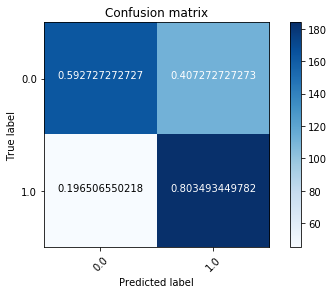

In [127]:
x_t = np.copy(X[0]) ; y_t = np.copy(Y[0])
x_t = x_t[0: :20] ; y_t = y_t[0: :20]
prd_l = prip.predict(x_t)
cnf = confusion_matrix(y_t,prd_l)
print("ela pasaka mou: %f" %prip.score(x_t,y_t))
prip_clf = prip.named_steps['classifier']
plot_confusion_matrix(cm = cnf, classes = prip_clf.classes_)
print(classification_report(y_t,prd_l))



In [11]:
# %%time
x_tot = np.copy(X[1]) ; y_tot = np.copy(Y[1])
x_tot = x_tot[0: :40] ; y_tot = y_tot[0: :40]
# plt.hist(y_tot)
# print(y_tot.shape)
# x_tot = Xsonar ; y_tot = ysonar
#Grid search for param tuning in SVM()
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

grid_pip = make_pipe(clf = SVC(), sca = StandardScaler(), order = 1)
# params = {'feature_selection__k': (33,12),
#          'decomp__n_components': (11,4),
#           'classifier__gamma' : ('auto',0.02, 0.2, 2),
#           'classifier__C': (1,10,100),
#          }
params = {'feature_selection__k': np.array([1000]),
         'decomp__n_components':np.array([50]),
          'classifier__gamma' : ('auto', 0.05,0.2, 2),
          'classifier__C': (1,10),
         }
grid_search = GridSearchCV(grid_pip, params, verbose = 1000, cv = cv)
grid_search.fit(x_tot, y_tot)
print("------ Grid search cv results for SVM ------")
print("Best score: %0.4f" %grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
     print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
winsound.Beep(400,900)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] feature_selection__k=1000, decomp__n_components=50, classifier__gamma=auto, classifier__C=1 
[CV]  feature_selection__k=1000, decomp__n_components=50, classifier__gamma=auto, classifier__C=1, score=0.803922, total=  20.7s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.8s remaining:    0.0s
[CV] feature_selection__k=1000, decomp__n_components=50, classifier__gamma=auto, classifier__C=1 
[CV]  feature_selection__k=1000, decomp__n_components=50, classifier__gamma=auto, classifier__C=1, score=0.862745, total=  20.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   41.2s remaining:    0.0s
[CV] feature_selection__k=1000, decomp__n_components=50, classifier__gamma=auto, classifier__C=1 
[CV]  feature_selection__k=1000, decomp__n_components=50, classifier__gamma=auto, classifier__C=1, score=0.784314, total=  20.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s
[CV] feature_select

In [31]:
#fit the model selected above to the whole training data
best_pip = make_pipe(clf = SVC(), sca = StandardScaler(), order = 1)
params = {'feature_selection__k': (100),
         'decomp__n_components': (100),
          'classifier__gamma' : ('auto'),
          'classifier__C': (10),
         }
best_pip.set_params(**params)
# weighted_clf = make_pipe(clf = SVC(), sca = StandardScaler(), order = 1)
# weighted_clf.set_params(**params)

x_ftrain, y_ftrain = np.copy(X[1]), np.copy(Y[1])
x_ftrain = x_ftrain[0: :40] ; y_ftrain = y_ftrain[0: :40]

best_pip.fit(x_ftrain,y_ftrain)
# weighted_clf.fit(x_ftrain,y_ftrain)

[LibSVM]

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', SelectKBest(k=100,
      score_func=<function mutual_info_classif at 0x0000009717697268>)), ('decomp', PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', to...',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True))])

0.706349206349
Normalized confusion matrix
[[ 0.64963504  0.35036496]
 [ 0.22608696  0.77391304]]
             precision    recall  f1-score   support

        0.0       0.77      0.65      0.71       137
        1.0       0.65      0.77      0.71       115

avg / total       0.72      0.71      0.71       252



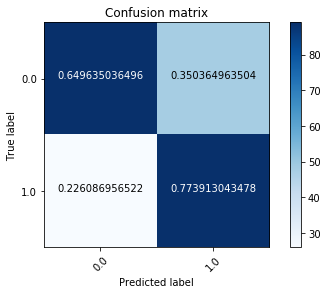

In [32]:
x_ftest, y_ftest = np.copy(X[0]),np.copy(Y[0])
x_ftest = x_ftest[0: :40] ; y_ftest = y_ftest[0: :40]

print(best_pip.score(x_ftest, y_ftest))
predicted_labels = best_pip.predict(x_ftest)
cmf = confusion_matrix(y_ftest,predicted_labels)
best_pip_clf = best_pip.named_steps['classifier']
plt.figure(0)
plot_confusion_matrix(cm = cmf, classes = best_pip_clf.classes_)

# print(weighted_clf.score(x_ftest, y_ftest))
# predicted_labels2 = weighted_clf.predict(x_ftest)
# cmf2 = confusion_matrix(y_ftest, predicted_labels2)
# weighted_clf_clf = weighted_clf.named_steps['classifier']
# plt.figure(1)
# plot_confusion_matrix(cm = cmf2, classes = weighted_clf_clf.classes_, title = 'weighted')


print(classification_report(y_ftest,predicted_labels))
# print(classification_report(y_ftest, predicted_labels2))

In [ ]:
http://stackoverflow.com/questions/35388647/how-to-use-gridsearchcv-output-for-a-scikit-prediction